In [1]:
import os
import sys

import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
from models.TrainPlanningOperator2D import PlanningOperator2D
from heuristics import generaterandompos
from heuristics import euclideannorm, FMM, dijkstra, planningoperator
from heuristics import testheuristiconmaps, testheuristiconsinglemap



Load Test Maps

In [2]:
Ntotal = 550
ntest = 50
sub = 1
Sx = Sy = int(((256 - 1) / sub) + 1)
maps = np.load('dataset/street_maps_256x256_dijkstra/mask.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]
# maps = maps[0,:,:].reshape(1,Sx,Sy)

Generate Random Start and Goal Positions on Maps

In [3]:
startpositions = generaterandompos(maps)
goalpositions = generaterandompos(maps)

Comparing Euclidean Norm, FMM, Dijkstra Heuristic

In [4]:
# Euclidean Norm
print("Testing Euclidean Norm")
euclidean_results = testheuristiconmaps(startpositions, goalpositions, maps, euclideannorm, plotresults=False, printvalues=False)


# FMM
print("Testing FMM")
fmm_results = testheuristiconmaps(startpositions, goalpositions, maps, FMM, plotresults=False, printvalues=False)

# Dijkstra
print("Testing Dijkstra")
dijkstra_results = testheuristiconmaps(startpositions, goalpositions, maps, dijkstra, plotresults=False, printvalues=False)


data = {
    "Heuristic": ["Euclidean Norm", "FMM", "Dijkstra"],
    "Avg Path Cost": [euclidean_results[0], fmm_results[0], dijkstra_results[0]],
    "Avg Planning Time": [euclidean_results[1], fmm_results[1], dijkstra_results[1]],
    "Avg Inference Time": [euclidean_results[2], fmm_results[2], dijkstra_results[2]],
    "Avg Nodes Expanded": [euclidean_results[3], fmm_results[3], dijkstra_results[3]],
    "Avg Success Rate": [euclidean_results[4], fmm_results[4], dijkstra_results[4]],
}


results_df = pd.DataFrame(data)


results_df

Testing Euclidean Norm
Testing FMM
Testing Dijkstra


,Heuristic,Avg Path Cost,Avg Planning Time,Avg Inference Time,Avg Nodes Expanded,Avg Success Rate
0,Euclidean Norm,151.164547,0.372760,0.004154,3936.48,1.0
1,FMM,151.192831,0.230038,0.037529,2328.04,1.0
2,Dijkstra,151.164547,0.111033,3.734683,1212.92,1.0


Planning Operator

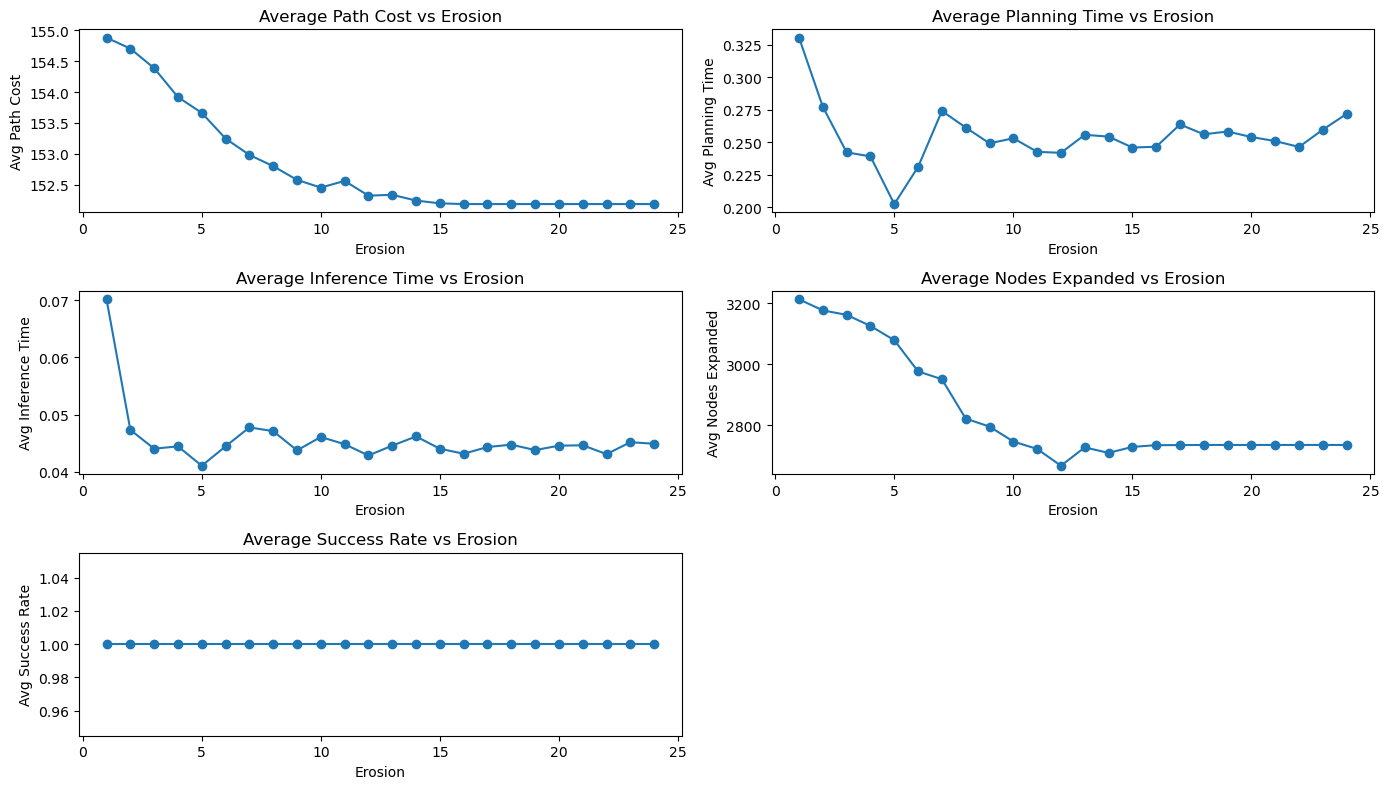

In [5]:
# Model
modes = 12
width = 32
nlayers = 5

model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("trained_models/modeldijkstra256.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []

# Run the loop and store results
for erode in range(1, 25):
    
    # Call your function and store the results
    avgpathcost, avgplantime, avginfertime, avgnodesexp, avgsuccessrate = testheuristiconmaps(
        startpositions, goalpositions, maps, planningoperator, model=model, erosion=erode, plotresults=False, printvalues=False
    )
    
    # Append results to lists
    erosion_values.append(erode)
    avgpathcost_values.append(avgpathcost)
    avgplantime_values.append(avgplantime)
    avginfertime_values.append(avginfertime)
    avgnodesexp_values.append(avgnodesexp)
    avgsuccessrate_values.append(avgsuccessrate)

# Plotting the results
plt.figure(figsize=(14, 8))

# Plot for avgpathcost
plt.subplot(3, 2, 1)
plt.plot(erosion_values, avgpathcost_values, marker='o')
plt.title('Average Path Cost vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Path Cost')

# Plot for avgplantime
plt.subplot(3, 2, 2)
plt.plot(erosion_values, avgplantime_values, marker='o')
plt.title('Average Planning Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Planning Time')

# Plot for avginfertime
plt.subplot(3, 2, 3)
plt.plot(erosion_values, avginfertime_values, marker='o')
plt.title('Average Inference Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Inference Time')

# Plot for avgnodesexp
plt.subplot(3, 2, 4)
plt.plot(erosion_values, avgnodesexp_values, marker='o')
plt.title('Average Nodes Expanded vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Nodes Expanded')

# Plot for avgsuccessrate
plt.subplot(3, 2, 5)
plt.plot(erosion_values, avgsuccessrate_values, marker='o')
plt.title('Average Success Rate vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Success Rate')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [7]:
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator, plotresults=False, printvalues=True, erosion = 5, model=model)

Average Path Cost: 153.66263771358385 
Average Planning Time: 0.2866331958770752 
Average Inference Time: 0.04811685562133789 
Average Number of Node Expansions: 3078.48 
Average Success Rate: 1.0
